<a href="https://colab.research.google.com/github/wandb/awesome-dl-projects/blob/master/ml-tutorial/EMNIST_Dense_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setups

In [1]:
!nvidia-smi

Tue Aug 25 21:17:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
tfds.disable_progress_bar()

from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%%capture
!pip install wandb

In [4]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Download EMNIST and Minor Investigation

Check out this [colab notebook]() for:
* More on `EMNIST/bymerge` dataset
* Class distribution

Check out [this paper](https://arxiv.org/abs/1702.05373) for more on EMNIST.

In [5]:
# Gather EMNIST/bymerge dataset
train_ds, validation_ds = tfds.load(
    "emnist/bymerge",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/emnist/bymerge/3.0.0.incomplete32MKLI/emnist-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/emnist/bymerge/3.0.0.incomplete32MKLI/emnist-test.tfrecord
Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/bymerge/3.0.0. Subsequent calls will reuse this data.


In [6]:
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

print(len(LABELS))

47


# Simple `tf.data` dataloader

Check out TensorFlow's [tutorial](https://www.tensorflow.org/guide/data) on `tf.data`.

In [12]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256

## We are transposing to rotate the image by 90 deg clockwise making the images human friendly.
def transpose_and_flatten(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32) # scale image pixels to [0,1]
  image = tf.transpose(image, [1,0,2]) # transpose to get human friendly image, since rotation
  image = tf.reshape(image, shape=(784,)) # permutation invariant or flatten 

  label = tf.one_hot(label, depth=len(LABELS))
  
  return image, label

trainloader = (
    train_ds
    .shuffle(1024)
    .map(transpose_and_flatten, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    validation_ds
    .map(transpose_and_flatten, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

#### Quick Visualization
(Run the cell below multiple times to visualize different images.)

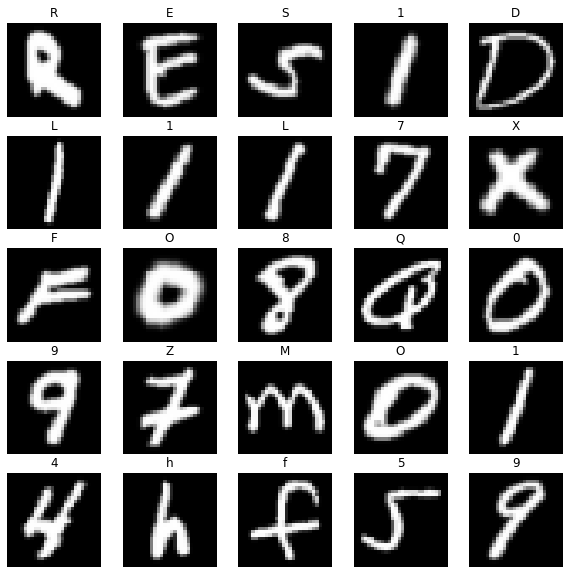

In [13]:
imgs, labels = next(iter(trainloader))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(tf.reshape(imgs[n], shape=(28,28)), cmap='gray')
    plt.title(LABELS[np.argmax(labels[n])])
    plt.axis('off')

# Simple classifier

#### Build Model

In [14]:
def DenseModel():
  inputs = Input(shape=(784,))
  x = Dense(256, activation='relu')(inputs)
  x = Dense(128, activation='relu')(x)
  # x = Dense(100, activation='relu')(x)
  outputs = Dense(len(LABELS), activation='softmax')(x)

  return Model(inputs=inputs, outputs=outputs)

In [15]:
tf.keras.backend.clear_session()
model = DenseModel()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 47)                6063      
Total params: 239,919
Trainable params: 239,919
Non-trainable params: 0
_________________________________________________________________


#### Callback

In [11]:
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=0, mode='auto', restore_best_weights=True
)

#### Train

In [16]:
# initialize wandb run
wandb.init(entity='wandb', project='emnist')

# hyperparameters
config = wandb.config
config.epochs = 70
config.learning_rate = 0.001

# model
tf.keras.backend.clear_session()
model = DenseModel()

# optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

# compile
model.compile(optimizer, 'categorical_crossentropy', metrics=['acc'])

# train
model.fit(trainloader,
          epochs=config.epochs,
          validation_data=testloader,
          callbacks=[WandbCallback(),
                     early_stopper])

Epoch 1/70
2318/2318 [==============================] - 111s 48ms/step - loss: 0.6136 - acc: 0.8100 - val_loss: 0.4303 - val_acc: 0.8557
Epoch 2/70
2318/2318 [==============================] - 115s 49ms/step - loss: 0.3942 - acc: 0.8651 - val_loss: 0.3897 - val_acc: 0.8620
Epoch 3/70
2318/2318 [==============================] - 118s 51ms/step - loss: 0.3533 - acc: 0.8763 - val_loss: 0.3654 - val_acc: 0.8728
Epoch 4/70
2318/2318 [==============================] - 121s 52ms/step - loss: 0.3307 - acc: 0.8824 - val_loss: 0.3596 - val_acc: 0.8721
Epoch 5/70
2318/2318 [==============================] - 119s 51ms/step - loss: 0.3146 - acc: 0.8870 - val_loss: 0.3527 - val_acc: 0.8766
Epoch 6/70
2318/2318 [==============================] - 116s 50ms/step - loss: 0.3030 - acc: 0.8903 - val_loss: 0.3474 - val_acc: 0.8786
Epoch 7/70
2318/2318 [==============================] - 120s 52ms/step - loss: 0.2936 - acc: 0.8929 - val_loss: 0.3529 - val_acc: 0.8769
Epoch 8/70
2318/2318 [===================

In [23]:
def plot_confusion_matrix():
  y_test = []
  y_preds = []
  for imgs, labels in tqdm(testloader):
      y_test.extend(np.argmax(labels, axis=1))
      y_pred = model.predict(imgs)
      y_preds.extend(np.argmax(y_pred, axis=1))

  cm = confusion_matrix(y_true = y_test, y_pred = y_preds)
  cm_normalize = normalize(cm, axis=1)

  plt.figure(figsize=(15,15));
  sns.heatmap(cm_normalize, annot=False, xticklabels=LABELS, yticklabels=LABELS, linewidths=.1);

  plt.savefig('confusion_matrix.png', bbox_inches='tight')

409it [00:26, 15.60it/s]


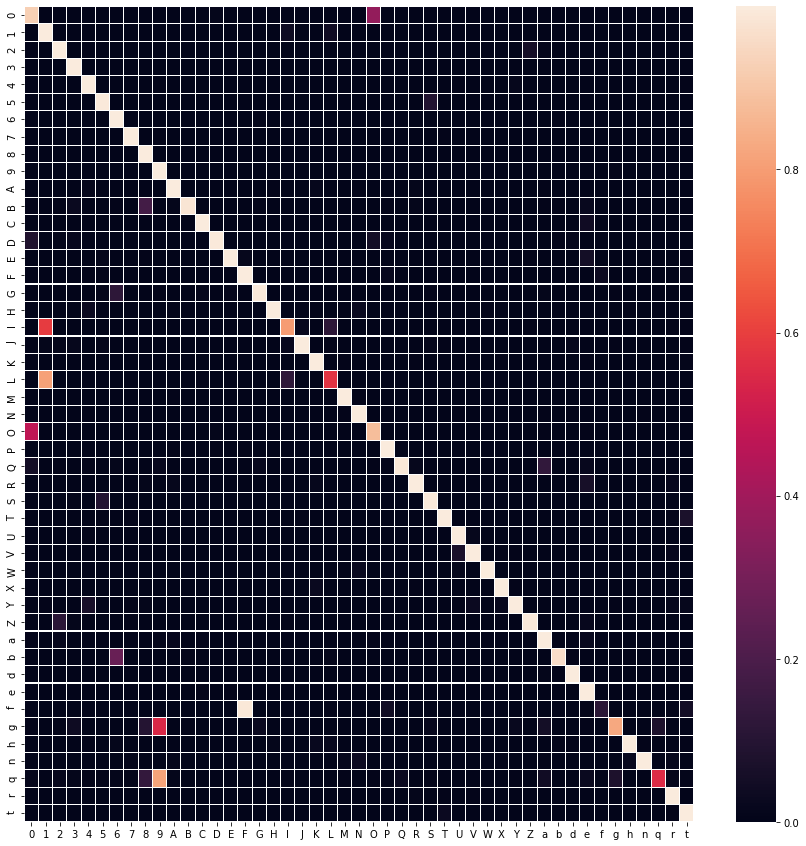

In [24]:
plot_confusion_matrix()

In [25]:
wandb.log({"image_confusion_matrix": [wandb.Image('confusion_matrix.png')]})